In [1]:
import sys
sys.path.append("../")

import itertools
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt
from rl.markov_process import *
from rl.chapter9.order_book import *
from dataclasses import dataclass, field
from rl.chapter9.optimal_order_execution import *
from rl.function_approx import *
from rl.distribution import Choose, Distribution, Gaussian, SampledDistribution, Poisson

plt.rcParams['figure.figsize'] = (15, 7)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

### Create the `OrderBookSimulator` class:

In [2]:
@dataclass(frozen=True)
class OrderBookSimulator(MarkovProcess):
    transitions : Dict[str, Distribution]
    num_orders : int
    order_types : List[str]
    order_weights : List[float]

    def print_state(self, state : OrderBook) -> None:
        print("Order Book:")
        print("--------------")
        print("Descending bids:")
        for s in state.state.descending_bids:
            print(s)
        
        print("\nAscending asks:")
        for s in state.state.ascending_asks:
            print(s)

    def transition(self, state: OrderBook) -> Optional[Distribution[OrderBook]]:
        '''
        here, we create 10 different orders and the resulting OrderBook
        and then pick one at random
        '''
        if not state.state.ascending_asks or not state.state.descending_bids:
            return None

        next_states = []
        for _ in range(self.num_orders):
            # randomly choose the type of order
            order_type = np.random.choice(self.order_types, p=self.order_weights)
            
            if order_type == 'market-buy':
                new_shares = self.transitions['market-shares'].sample()
                _, next_state = state.state.buy_market_order(shares=new_shares)

            elif order_type == 'market-sell':
                new_shares = self.transitions['market-shares'].sample()
                _, next_state = state.state.sell_market_order(shares=new_shares)
            
            elif order_type == 'limit-buy':
                # ensure that the random price is lower than the current ask price
                new_price = self.transitions['limit-price'].sample()

                while new_price >= state.state.ask_price():
                    new_price = self.transitions['limit-price'].sample()

                new_shares = self.transitions['limit-shares'].sample()
                _, next_state = state.state.buy_limit_order(price=round(new_price, 2), shares=new_shares)
            
            elif order_type == 'limit-sell':
                # ensure that the random price is greater than the current bid price
                new_price = self.transitions['limit-price'].sample()

                while new_price <= state.state.bid_price():
                    new_price = self.transitions['limit-price'].sample()

                new_shares = self.transitions['limit-shares'].sample()
                _, next_state = state.state.sell_limit_order(price=round(new_price, 2), shares=new_shares)

            next_states.append(NonTerminal(next_state))
        
        return Choose(next_states)

### Create an `OrderBook` instance and see how the book looks like:

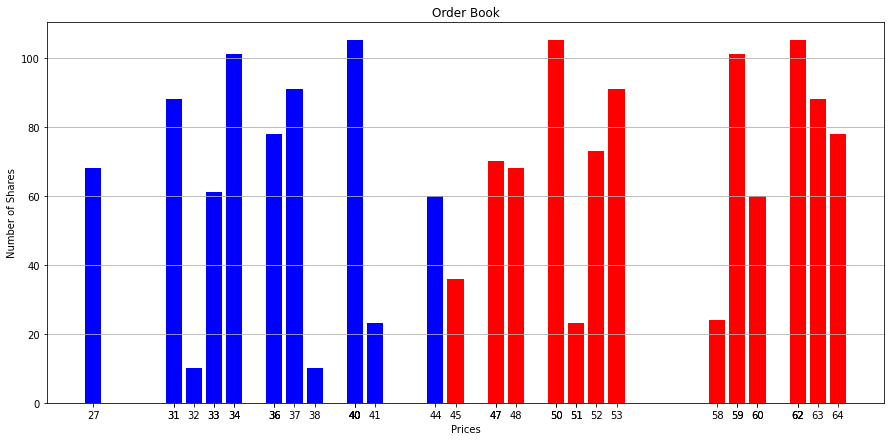

In [3]:
num_asks = 20
num_bids = 20

prices : Sequence[float] = np.random.randint(low=45.0, high=65.0, size=num_asks)
shares : Sequence[int] = np.random.randint(10, 120, size=num_asks)
asks_list = sorted([DollarsAndShares(dollars=round(p, 2), shares=s) for p, s in zip(prices, shares)], key=lambda x : x.dollars, reverse=True)

prices : Sequence[float] = np.random.randint(low=25.0, high=45.0, size=num_asks)
bids_list = sorted([DollarsAndShares(dollars=round(p, 2), shares=s) for p, s in zip(prices, shares)], key=lambda x : x.dollars)


book : OrderBook = NonTerminal(OrderBook(descending_bids=bids_list, ascending_asks=asks_list))
book.state.display_order_book()

### Set up the distributions of the prices and the shares for the simulator and then create an instance of the `OrderBookSimulator`:

In [4]:
transitions = {'market-shares' : SampledDistribution(sampler=lambda : np.random.randint(10, 41)), 
               'limit-price' : SampledDistribution(sampler=lambda : np.random.uniform(40, 61)), 
               'limit-shares' : SampledDistribution(sampler=lambda : np.random.randint(10, 41))}

simulator = OrderBookSimulator(transitions=transitions, 
                               num_orders=10, 
                               order_types=['market-buy', 'market-sell', 'limit-buy', 'limit-sell'], 
                               order_weights=[0.25] * 4)

### Create 5 outputs of the `OrderBookSimulator` changes:

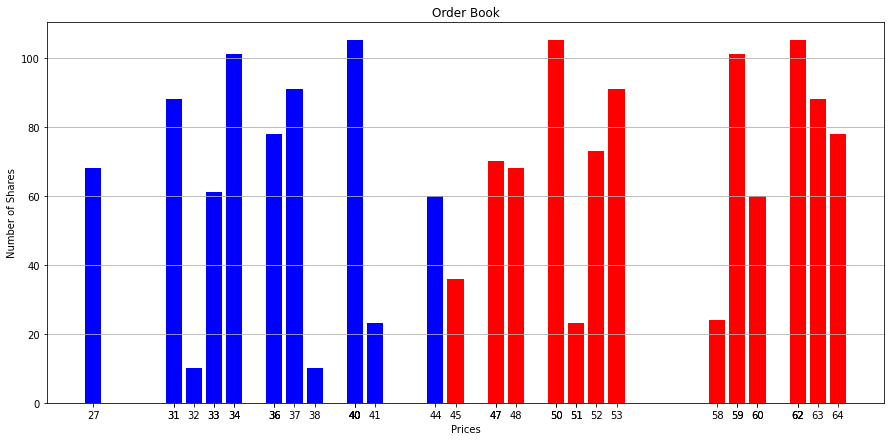

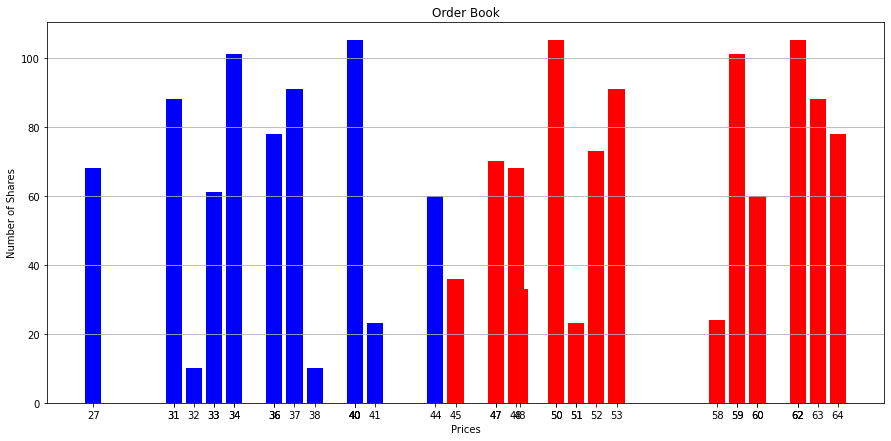

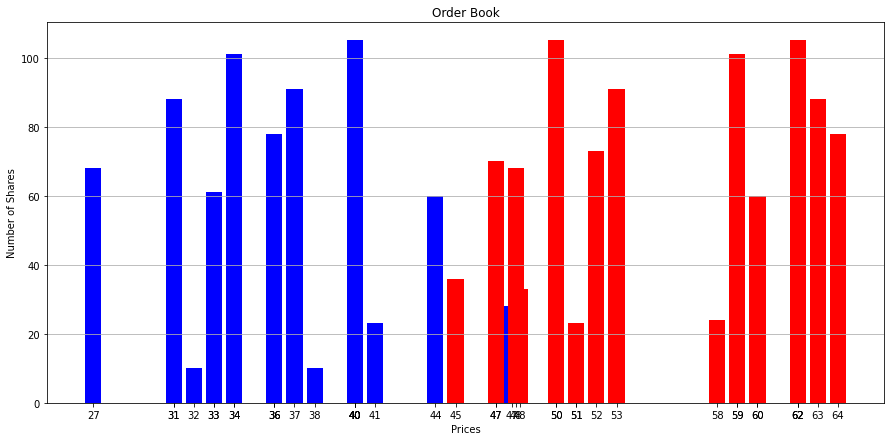

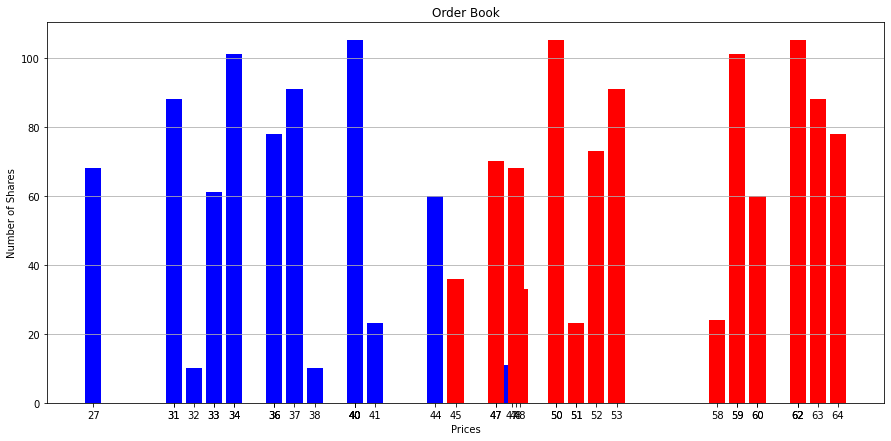

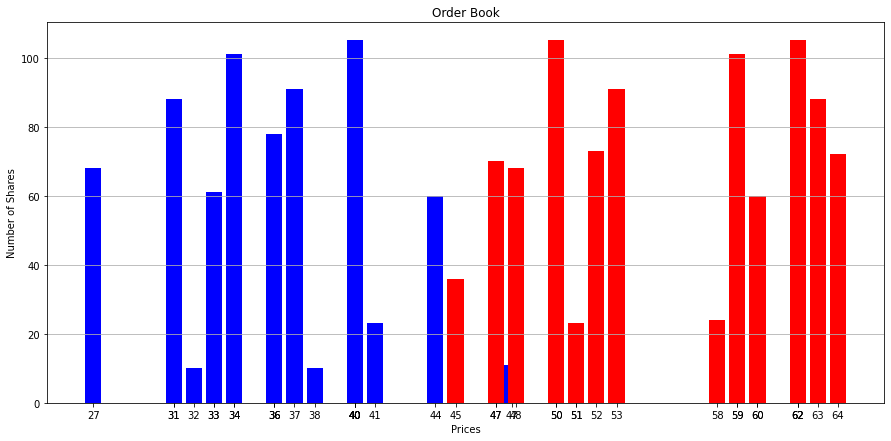

In [5]:
ob_generator = simulator.simulate(Choose([book]))

samples = [i for i in itertools.islice(ob_generator, 5)]

for i in samples:
    i.state.display_order_book()

### Graph the best ask/bid prices and mid price over time:

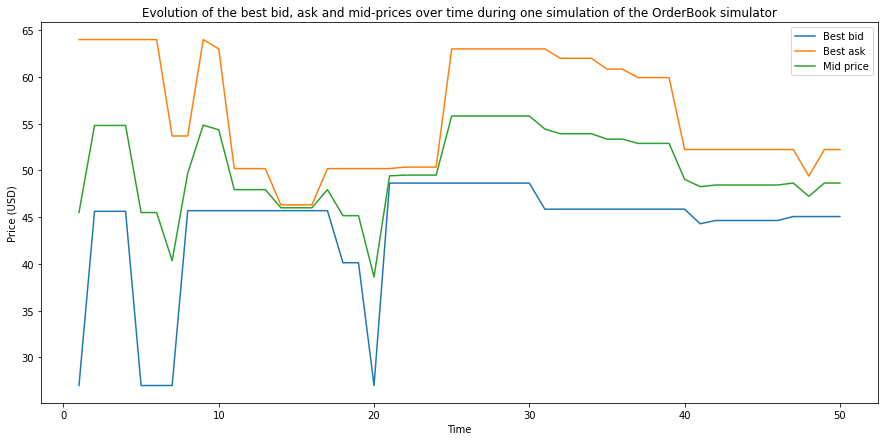

In [6]:
num_traces = 50
time = range(1, 1 + num_traces)

ob_generator = simulator.simulate(Choose([book]))
trace = [order_book for order_book in itertools.islice(ob_generator, num_traces)]

best_bid = [order_book.state.bid_price() for order_book in trace]
best_ask = [order_book.state.ask_price() for order_book in trace]
mid_price = [order_book.state.mid_price() for order_book in trace]

plt.plot(time, best_bid, label = 'Best bid')
plt.plot(time, best_ask, label = 'Best ask')
plt.plot(time, mid_price, label = 'Mid price')

plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Evolution of the best bid, ask and mid-prices over time during one simulation of the OrderBook simulator")
plt.legend()
plt.show()

### Seeing how the bid-ask spread evolves over time:

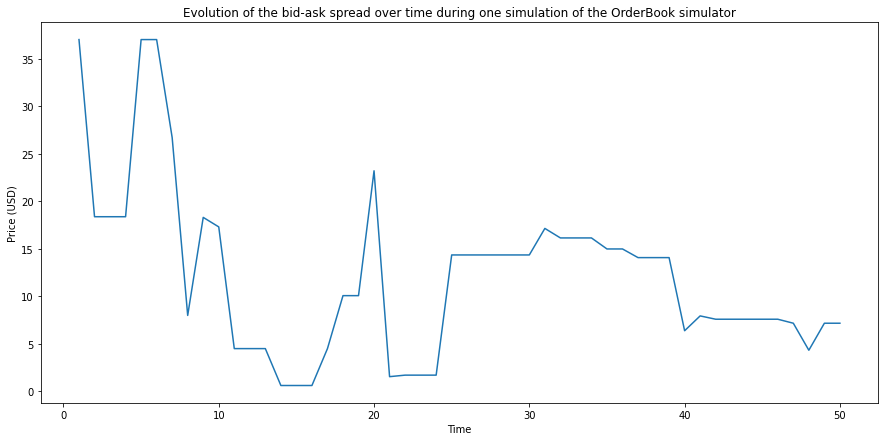

In [7]:
spread = [order_book.state.bid_ask_spread() for order_book in trace]

plt.plot(time, spread)

plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Evolution of the bid-ask spread over time during one simulation of the OrderBook simulator")
plt.show()

# Question 2

In [54]:
@dataclass(frozen=True)
class PriceAndShares:
    price: float
    shares: int
    market_factor : float

@dataclass(frozen=True)
class OptimalOrderExecution:
    shares : int
    market_factor : float
    time_steps : int
    avg_price_diff : Sequence[Callable[[PriceAndShares], float]]
    price_dynamics : Sequence[Callable[[PriceAndShares], Distribution[float]]]
    market_dynamics : Sequence[Callable[[PriceAndShares], Distribution[float]]]
    utility : Callable[[float], float]
    discount_factor : float 
    func_approx : ValueFunctionApprox[PriceAndShares]
    initial_price_distr : Distribution[float]

    def get_mdp(self, t : int) -> MarkovDecisionProcess[PriceAndShares, int]:
        utility_f : Callable[[float], float] = self.utility
        price_diff : Sequence[Callable[[PriceAndShares], float]] = self.avg_price_diff
        dynamics : Sequence[Callable[[PriceAndShares], Distribution[float]]] = self.price_dynamics
        market_dynamics : Sequence[Callable[[PriceAndShares], Distribution[float]]] = self.market_dynamics
        steps : int = self.time_steps

        class OptimalExecutionMDP(MarkovDecisionProcess[PriceAndShares, int]):
            def step(self, p_r : NonTerminal[PriceAndShares], sell : int) -> SampledDistribution[Tuple[State[PriceAndShares], float]]:
                def sampler(p_r=p_r, sell=sell) -> Tuple[State[PriceAndShares], float]:
                    p_s : NonTerminal[PriceAndShares] = NonTerminal(PriceAndShares(price=p_r.state.price, shares=p_r.state.shares, market_factor=p_r.state.market_factor))
                    next_price : float = dynamics[t](p_s).sample()
                    next_rem : int = p_r.state.shares - sell
                    mar : float = market_dynamics[t](p_r).sample()

                    # if next_rem < 0:
                    #     next_rem = 0
                        
                    next_state : NonTerminal[PriceAndShares] = PriceAndShares(price=next_price, shares=next_rem, market_factor=mar)
                    reward : float = utility_f(sell * (p_r.state.price - price_diff[t](p_s)))

                    return (NonTerminal(next_state), reward)
                
                return SampledDistribution(sampler=sampler, expectation_samples=100)
            
            def actions(self, p_s : NonTerminal[PriceAndShares]) -> Iterator[int]:
                if t == steps - 1:
                    return iter([p_s.state.shares])
                else:
                    return iter([p_s.state.shares + 1])
            
        return OptimalExecutionMDP()

    def get_start_distribution(self, t : int) -> SampledDistribution[NonTerminal[PriceAndShares]]:
        def states_sampler() -> NonTerminal[PriceAndShares]:
            price : float = self.initial_price_distr.sample()
            rem : int = self.shares
            mar : float = self.market_factor

            for i in range(t):
                state = NonTerminal(PriceAndShares(price, rem, mar))
                next_sell : int = Choose(range(rem + 1)).sample()
                price : float = self.price_dynamics[i](state).sample()
                rem -= next_sell
                mar = self.market_dynamics[i](state).sample()

                # if rem < 0:
                #     rem = 0
            
            return NonTerminal(PriceAndShares(price, rem, mar))

        return SampledDistribution(states_sampler)

    def backward_induction_vf_and_pi(self) -> Iterator[Tuple[ValueFunctionApprox[PriceAndShares], DeterministicPolicy[PriceAndShares, int]]]:
        mdp_f0_mu_triples: Sequence[Tuple[MarkovDecisionProcess[PriceAndShares, int], ValueFunctionApprox[PriceAndShares], SampledDistribution[NonTerminal[PriceAndShares]]]] = [(
            self.get_mdp(i),
            self.func_approx,
            self.get_start_distribution(i)
        ) for i in range(self.time_steps)]

        num_state_samples: int = 10000
        error_tolerance: float = 1e-6

        return back_opt_vf_and_policy(
            mdp_f0_mu_triples=mdp_f0_mu_triples,
            γ=self.discount_factor,
            num_state_samples=num_state_samples,
            error_tolerance=error_tolerance)

### Set up the problem and use a `LinearFunctionApprox` object for the function approximation:

In [55]:
init_price_mean: float = 100.0
init_price_std: float = 10.0
init_market_factor: float = 0.1
num_shares: int = 100
time_steps: int = 5
beta: float = 0.05
theta: float = 0.08
rho: float = 0.8
mean_z: float = 0.01
var_z: float = 0.005

start_distribution = Gaussian(init_price_mean, init_price_std)

market_dynamics = [lambda pr : Gaussian(pr.state.market_factor * rho, 2.0) for _ in range(time_steps)]
price_diff = [lambda pr : pr.state.price * (beta * pr.state.shares + theta * pr.state.market_factor) for _ in range(time_steps)]
price_dynamics = [lambda pr : Gaussian(mean_z, var_z).apply(lambda x : Choose([pr.state.price * np.exp(x)])) for _ in range(time_steps)]

ffs = [lambda _ : 1.0,
       lambda ps : ps.state.shares,
       lambda ps : ps.state.market_factor,
       lambda ps : ps.state.price,
       lambda ps : ps.state.price * ps.state.shares,
       lambda ps : ps.state.price * ps.state.market_factor,
       lambda ps : ps.state.shares ** 2,
       lambda ps : ps.state.market_factor ** 2,
       lambda ps : ps.state.shares * ps.state.market_factor]

fa : FunctionApprox = LinearFunctionApprox.create(feature_functions=ffs)

OOE = OptimalOrderExecution(shares = num_shares,
                            market_factor = init_market_factor,
                            time_steps = time_steps,
                            avg_price_diff = price_diff,
                            price_dynamics = price_dynamics,
                            market_dynamics = market_dynamics,
                            utility = lambda x : x,
                            discount_factor = 1.0,
                            func_approx = fa,
                            initial_price_distr = start_distribution)

### Uncomment the following if you want to use Deep Learning for function approximation, instead of linear regression:

In [56]:
# ffs = [lambda ps : ps.state.shares,
#        lambda ps : ps.state.market_factor,
#        lambda ps : ps.state.price,
#        lambda ps : ps.state.price * ps.state.shares,
#        lambda ps : ps.state.price * ps.state.market_factor,
#        lambda ps : ps.state.shares ** 2,
#        lambda ps : ps.state.market_factor ** 2,
#        lambda ps : ps.state.shares * ps.state.market_factor]
       
       
# dnn_spec = DNNSpec(
#     neurons=[2, 10, 20, 10, 2],
#     bias=True,
#     hidden_activation=lambda x : np.maximum(x, 0.001 * x),
#     hidden_activation_deriv=lambda x : 0.001 if x <= 0 else 1.0,
#     output_activation=lambda x : x,
#     output_activation_deriv=lambda x : np.ones_like(x)
# )

# dnna = DNNApprox.create(feature_functions=ffs, dnn_spec=dnn_spec, regularization_coeff=0.01, adam_gradient=AdamGradient(0.5, 0.9, 0.999))


# OOE = OptimalOrderExecution(shares = num_shares,
#                             market_factor = init_market_factor,
#                             time_steps = time_steps,
#                             avg_price_diff = price_diff,
#                             price_dynamics = price_dynamics,
#                             market_dynamics = market_dynamics,
#                             utility = lambda x : x,
#                             discount_factor = 1.0,
#                             func_approx = dnna,
#                             initial_price_distr = start_distribution)

In [57]:
it_vf = OOE.backward_induction_vf_and_pi()

state = PriceAndShares(price = init_price_mean, shares = num_shares, market_factor = init_market_factor)
    

print("Backward Induction: VF and Policy:")
print("----------------------------------")
print()
for t, (vf, pol) in enumerate(it_vf):
    print(f"Time {t:d}")
    print()
    opt_sale: int = pol.action_for(state)
    val: float = vf(NonTerminal(state))
    print(f"Optimal Sales = {opt_sale:d}, Opt Val = {val:.3f}")
    print()
    print("Optimal Weights below:")
    print(vf.weights.weights)
    print()

# print("Analytical Solution")
# print("-------------------")
# print()



# for t in range(num_time_steps):
#     print(f"Time {t:d}")
#     print()

Backward Induction: VF and Policy:
----------------------------------

Time 0

Optimal Sales = 101, Opt Val = -40599.362

Optimal Weights below:
[-6802.501 -3642.463 -475295.471 -1135.078 -19.549 28352.018 44.017
 2373111.207 -6044.812]

Time 1

Optimal Sales = 101, Opt Val = -40730.038

Optimal Weights below:
[-14662.626 505.384 624.979 145.005 -4.051 -6.210 -5.052 -0.366 -8.069]

Time 2

Optimal Sales = 101, Opt Val = -40911.595

Optimal Weights below:
[-5806.387 368.985 266.241 56.865 -2.672 -2.650 -5.088 0.145 -8.153]

Time 3

Optimal Sales = 101, Opt Val = -41613.056

Optimal Weights below:
[-2037.987 268.434 124.889 19.690 -1.638 -1.228 -5.192 0.092 -8.373]

Time 4

Optimal Sales = 101, Opt Val = -40997.859

Optimal Weights below:
[-489.048 182.355 49.290 4.732 -0.767 -0.487 -5.147 -0.026 -8.063]

